In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import torch
from torch import nn, tensor
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import transforms, ToTensor
import torchvision.utils as vutils


MODEL_E_PATH = "ffhq-64x64-e.pth"
MODEL_G_PATH = "ffhq-64x64-g.pth"
MODEL_D_PATH = "ffhq-64x64-d.pth"
EXPORT_PATH = "raw-weights-ffhq-64x64"


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [2]:

class FFHQDataset(Dataset):

    def __init__(self, transform=None, target_transform=None):
        self.size = 64
        self.path = f"../data/FFHQ/{self.size}x{self.size}/"
        self.raw_bytes = {}
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        #return 10000
        return 70000

    def __getitem__(self, i):
        bd = i - i % 1000
        filepath = self.path + "{:05d}.raw".format(bd)
        if filepath not in self.raw_bytes:
            content = np.fromfile(filepath, dtype=np.uint8)
            content = content.reshape((1000, 3, self.size, self.size))
            self.raw_bytes[filepath] = content
        else:
            content = self.raw_bytes[filepath]
        return content[i%1000].astype(np.float32) / 255.0


def load_data(dataset, plot=False):
    dataloader = DataLoader(
        dataset,
        batch_size=128,
        shuffle=True
    )
    for x in dataloader:
        print("Shape of x:", x.shape)
        break
    if plot:
        plt.figure(figsize=(8, 8))
        plt.axis("off")
        plt.title("Training Images")
        plt.imshow(np.transpose(vutils.make_grid(
            next(iter(dataloader)).to(device)[:64],
            padding=2, pad_value=0.5, normalize=True).cpu(), (1, 2, 0)),
                   interpolation='nearest')
        plt.show()
    return dataloader


In [3]:
LATENT = 64
DIMS_E = [32, 64, 64, 32]
DIMS_G = [64, 64, 64, 64, 64, 3, -1, -1]

# activation = nn.ReLU
activation = nn.SiLU

class Encoder(nn.Module):

    def __init__(self):
        super(Encoder, self).__init__()
        # Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0)
        dims = DIMS_E
        self.main = nn.Sequential(
            # 3 x 64x64
            nn.Conv2d(3, dims[0], 4, 2, 1, bias=False),
            nn.BatchNorm2d(dims[0]),
            activation(inplace=True),
            # dims[0] x 32x32
            nn.Conv2d(dims[0], dims[1], 4, 2, 1, bias=False),
            nn.BatchNorm2d(dims[1]),
            activation(inplace=True),
            # dims[1] x 16x16
            nn.Conv2d(dims[1], dims[2], 4, 2, 1, bias=False),
            nn.BatchNorm2d(dims[2]),
            activation(inplace=True),
            # dims[2] x 8x8
            nn.Conv2d(dims[2], dims[3], 4, 2, 1, bias=False),
            nn.BatchNorm2d(dims[3]),
            activation(inplace=True),
            # dims[3] x 4x4
            nn.Conv2d(dims[3], LATENT, 4, 1, 0, bias=False),
            nn.Flatten()
        )

    def forward(self, x):
        return self.main(x)


class Generator(nn.Module):

    def __init__(self):
        super(Generator, self).__init__()
        # ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0)
        # https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md
        dims = DIMS_G
        layers = [
            # LATENT
            nn.Linear(LATENT, dims[0]*4*4, bias=True),
            activation(inplace=True),
            nn.Unflatten(1, (dims[0], 4, 4)),
            nn.Conv2d(dims[0], dims[1], 3, 1, 1, bias=False),
            nn.BatchNorm2d(dims[1]),
            activation(inplace=True),
            # dims[1] x 4x4
            nn.ConvTranspose2d(dims[1], dims[2], 4, 2, 1, bias=False),
            nn.BatchNorm2d(dims[2]),
            activation(inplace=True),
            # dims[2] x 8x8
            nn.ConvTranspose2d(dims[2], dims[3], 4, 2, 1, bias=False),
            nn.BatchNorm2d(dims[3]),
            activation(inplace=True),
            # dims[3] x 16x16
            nn.ConvTranspose2d(dims[3], dims[4], 4, 2, 1, bias=False),
            nn.BatchNorm2d(dims[4]),
            activation(inplace=True),
            # dims[4] x 32x32
            nn.ConvTranspose2d(dims[4], dims[5], 4, 2, 1, bias=False),
            nn.BatchNorm2d(dims[5]),
            # nn.SiLU(inplace=True),
            # nn.Conv2d(dims[5], dims[6], 3, 1, 1, bias=False),
            # nn.SiLU(inplace=True),
            # nn.Conv2d(dims[6], 3, 3, 1, 1, bias=False),
            nn.Tanh()
            # 3 x 64x64
        ]
        layers = [layer for layer in layers if layer is not None]
        self.main = nn.Sequential(*layers)

    def forward(self, x):
        return self.main(x)


Shape of x: torch.Size([128, 3, 64, 64])
Encoder 165760
Encoder(
  (main): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): SiLU(inplace=True)
    (6): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): SiLU(inplace=True)
    (9): Conv2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): SiLU(inplace=True)
    (12): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (13): Flatten(start_

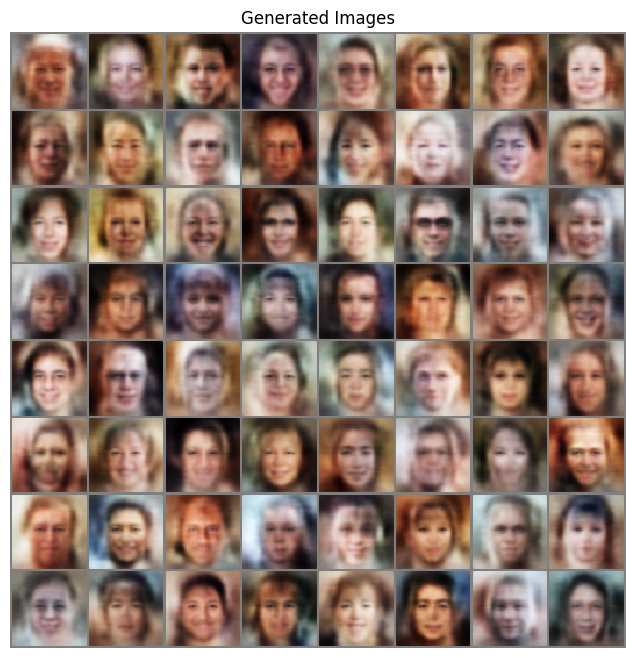

Epoch 2
[100/547]  loss: (l1=0.0899 ssim=0.4601 -> 0.4912) vae=0.1089 -> 0.6001
[200/547]  loss: (l1=0.0850 ssim=0.4456 -> 0.4682) vae=0.1166 -> 0.5848
[300/547]  loss: (l1=0.0852 ssim=0.4430 -> 0.4681) vae=0.1205 -> 0.5886
[400/547]  loss: (l1=0.0853 ssim=0.4314 -> 0.4643) vae=0.1117 -> 0.5760
[500/547]  loss: (l1=0.0819 ssim=0.4347 -> 0.4530) vae=0.1103 -> 0.5633
Epoch 3
[100/547]  loss: (l1=0.0823 ssim=0.4236 -> 0.5720) vae=0.1159 -> 0.6879
[200/547]  loss: (l1=0.0766 ssim=0.4142 -> 0.5464) vae=0.1098 -> 0.6562
[300/547]  loss: (l1=0.0801 ssim=0.4174 -> 0.5601) vae=0.1111 -> 0.6713
[400/547]  loss: (l1=0.0799 ssim=0.4081 -> 0.5530) vae=0.1057 -> 0.6586
[500/547]  loss: (l1=0.0801 ssim=0.4052 -> 0.5515) vae=0.1053 -> 0.6568
Epoch 4
[100/547]  loss: (l1=0.0814 ssim=0.4145 -> 0.6811) vae=0.1114 -> 0.7925
[200/547]  loss: (l1=0.0803 ssim=0.4082 -> 0.6708) vae=0.1102 -> 0.7810
[300/547]  loss: (l1=0.0766 ssim=0.3898 -> 0.6406) vae=0.1094 -> 0.7500
[400/547]  loss: (l1=0.0754 ssim=0.3744 

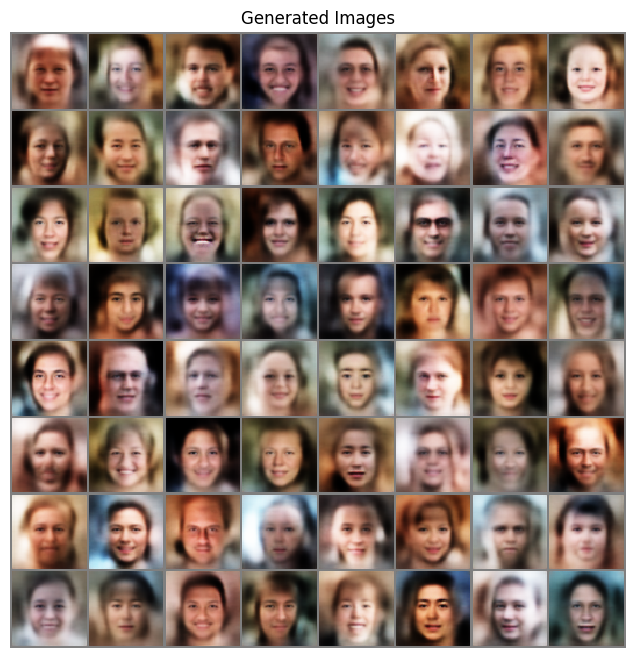

Epoch 5
[100/547]  loss: (l1=0.0772 ssim=0.3802 -> 0.7398) vae=0.1063 -> 0.8461
[200/547]  loss: (l1=0.0783 ssim=0.3868 -> 0.7520) vae=0.1121 -> 0.8641
[300/547]  loss: (l1=0.0771 ssim=0.3835 -> 0.7443) vae=0.1097 -> 0.8540
[400/547]  loss: (l1=0.0777 ssim=0.3737 -> 0.7318) vae=0.1054 -> 0.8371
[500/547]  loss: (l1=0.0792 ssim=0.3837 -> 0.7499) vae=0.1145 -> 0.8645
Epoch 6
[100/547]  loss: (l1=0.0790 ssim=0.3820 -> 0.8546) vae=0.1116 -> 0.9662
[200/547]  loss: (l1=0.0785 ssim=0.3783 -> 0.8469) vae=0.1066 -> 0.9535
[300/547]  loss: (l1=0.0787 ssim=0.3751 -> 0.8417) vae=0.1142 -> 0.9559
[400/547]  loss: (l1=0.0799 ssim=0.3799 -> 0.8530) vae=0.1112 -> 0.9642
[500/547]  loss: (l1=0.0768 ssim=0.3630 -> 0.8159) vae=0.1125 -> 0.9283
Epoch 7
[100/547]  loss: (l1=0.0751 ssim=0.3568 -> 0.9013) vae=0.1074 -> 1.0088
[200/547]  loss: (l1=0.0796 ssim=0.3642 -> 0.9255) vae=0.1100 -> 1.0355
[300/547]  loss: (l1=0.0841 ssim=0.3719 -> 0.9503) vae=0.1007 -> 1.0510
[400/547]  loss: (l1=0.0802 ssim=0.3692 

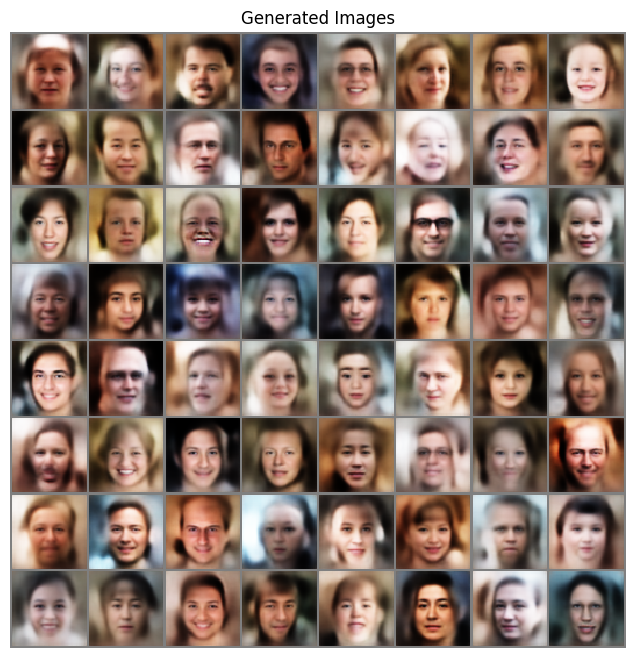

Epoch 10
[100/547]  loss: (l1=0.0827 ssim=0.3602 -> 1.2186) vae=0.1039 -> 1.3225
[200/547]  loss: (l1=0.0825 ssim=0.3511 -> 1.1894) vae=0.1048 -> 1.2942
[300/547]  loss: (l1=0.0816 ssim=0.3464 -> 1.1737) vae=0.1106 -> 1.2843
[400/547]  loss: (l1=0.0819 ssim=0.3511 -> 1.1890) vae=0.1072 -> 1.2962
[500/547]  loss: (l1=0.0855 ssim=0.3456 -> 1.1741) vae=0.1049 -> 1.2790
Epoch 11
[100/547]  loss: (l1=0.0829 ssim=0.3477 -> 1.1791) vae=0.1053 -> 1.2844
[200/547]  loss: (l1=0.0827 ssim=0.3460 -> 1.1733) vae=0.1036 -> 1.2769
[300/547]  loss: (l1=0.0805 ssim=0.3401 -> 1.1527) vae=0.1074 -> 1.2600
[400/547]  loss: (l1=0.0811 ssim=0.3453 -> 1.1700) vae=0.1107 -> 1.2807
[500/547]  loss: (l1=0.0831 ssim=0.3420 -> 1.1609) vae=0.1063 -> 1.2672
Epoch 12
[100/547]  loss: (l1=0.0836 ssim=0.3436 -> 1.1663) vae=0.1022 -> 1.2685
[200/547]  loss: (l1=0.0830 ssim=0.3468 -> 1.1760) vae=0.1098 -> 1.2858
[300/547]  loss: (l1=0.0824 ssim=0.3378 -> 1.1470) vae=0.1049 -> 1.2519
[400/547]  loss: (l1=0.0840 ssim=0.35

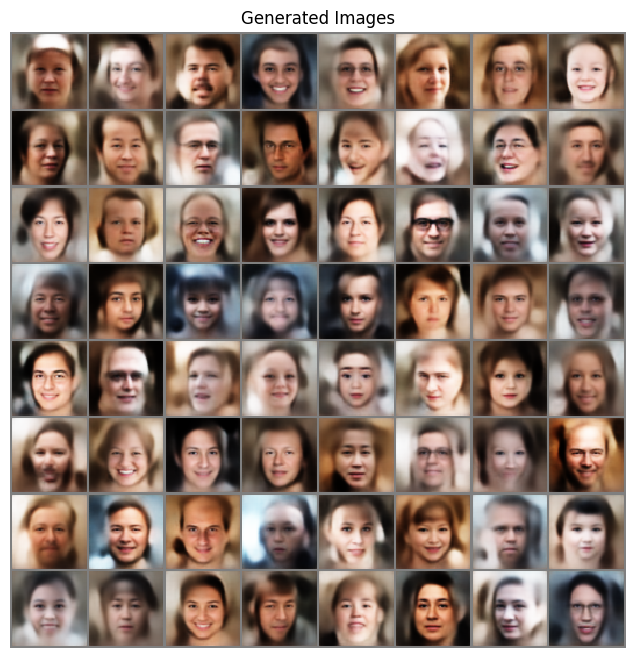

Epoch 17
[100/547]  loss: (l1=0.0790 ssim=0.3263 -> 1.1072) vae=0.1055 -> 1.2127
[200/547]  loss: (l1=0.0846 ssim=0.3395 -> 1.1540) vae=0.1038 -> 1.2578
[300/547]  loss: (l1=0.0844 ssim=0.3360 -> 1.1428) vae=0.1050 -> 1.2477
[400/547]  loss: (l1=0.0807 ssim=0.3295 -> 1.1190) vae=0.0992 -> 1.2182
[500/547]  loss: (l1=0.0815 ssim=0.3306 -> 1.1231) vae=0.1117 -> 1.2348
Epoch 18
[100/547]  loss: (l1=0.0845 ssim=0.3363 -> 1.1437) vae=0.1100 -> 1.2536
[200/547]  loss: (l1=0.0877 ssim=0.3441 -> 1.1711) vae=0.1083 -> 1.2795
[300/547]  loss: (l1=0.0802 ssim=0.3354 -> 1.1374) vae=0.1112 -> 1.2486
[400/547]  loss: (l1=0.0782 ssim=0.3193 -> 1.0844) vae=0.1036 -> 1.1880
[500/547]  loss: (l1=0.0806 ssim=0.3300 -> 1.1204) vae=0.1108 -> 1.2311
Epoch 19
[100/547]  loss: (l1=0.0815 ssim=0.3305 -> 1.1229) vae=0.1138 -> 1.2367
[200/547]  loss: (l1=0.0842 ssim=0.3357 -> 1.1416) vae=0.1052 -> 1.2468
[300/547]  loss: (l1=0.0805 ssim=0.3184 -> 1.0832) vae=0.1036 -> 1.1868
[400/547]  loss: (l1=0.0841 ssim=0.33

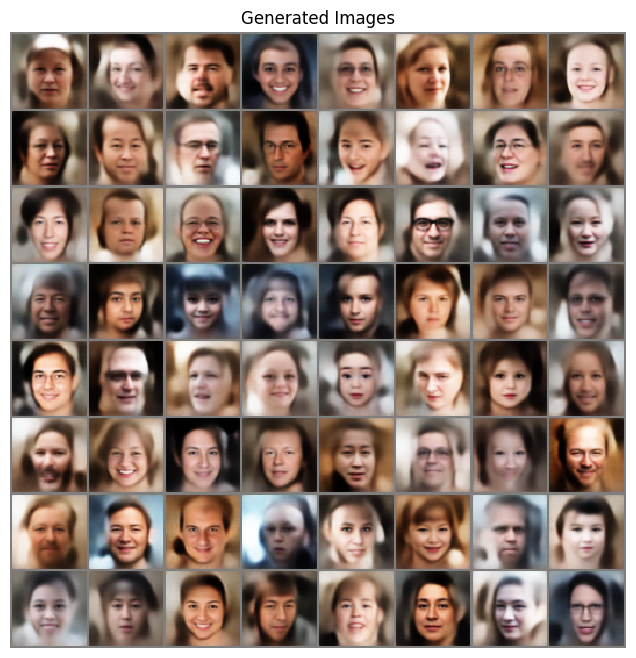

Epoch 26
[100/547]  loss: (l1=0.0811 ssim=0.3283 -> 1.1154) vae=0.1083 -> 1.2237
[200/547]  loss: (l1=0.0785 ssim=0.3138 -> 1.0669) vae=0.1068 -> 1.1738
[300/547]  loss: (l1=0.0818 ssim=0.3256 -> 1.1072) vae=0.1077 -> 1.2150
[400/547]  loss: (l1=0.0813 ssim=0.3228 -> 1.0981) vae=0.1073 -> 1.2055
[500/547]  loss: (l1=0.0776 ssim=0.3181 -> 1.0800) vae=0.0995 -> 1.1795
Epoch 27
[100/547]  loss: (l1=0.0781 ssim=0.3093 -> 1.0523) vae=0.1080 -> 1.1603
[200/547]  loss: (l1=0.0808 ssim=0.3246 -> 1.1034) vae=0.1085 -> 1.2119
[300/547]  loss: (l1=0.0831 ssim=0.3346 -> 1.1372) vae=0.1022 -> 1.2394
[400/547]  loss: (l1=0.0811 ssim=0.3252 -> 1.1054) vae=0.1060 -> 1.2115
[500/547]  loss: (l1=0.0805 ssim=0.3240 -> 1.1012) vae=0.1125 -> 1.2137
Epoch 28
[100/547]  loss: (l1=0.0794 ssim=0.3196 -> 1.0861) vae=0.1016 -> 1.1877
[200/547]  loss: (l1=0.0848 ssim=0.3219 -> 1.0978) vae=0.1064 -> 1.2041
[300/547]  loss: (l1=0.0800 ssim=0.3224 -> 1.0957) vae=0.1036 -> 1.1993
[400/547]  loss: (l1=0.0848 ssim=0.31

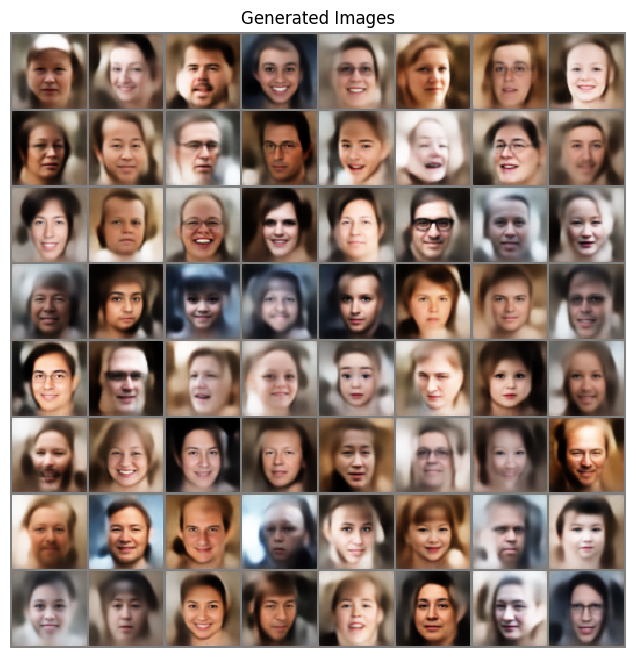

Epoch 37
[100/547]  loss: (l1=0.0794 ssim=0.3133 -> 1.0661) vae=0.1078 -> 1.1738
[200/547]  loss: (l1=0.0789 ssim=0.3146 -> 1.0698) vae=0.1118 -> 1.1815
[300/547]  loss: (l1=0.0807 ssim=0.3171 -> 1.0794) vae=0.1032 -> 1.1826
[400/547]  loss: (l1=0.0817 ssim=0.3195 -> 1.0878) vae=0.1064 -> 1.1942
[500/547]  loss: (l1=0.0827 ssim=0.3275 -> 1.1141) vae=0.1078 -> 1.2219
Epoch 38
[100/547]  loss: (l1=0.0779 ssim=0.3080 -> 1.0479) vae=0.1004 -> 1.1483
[200/547]  loss: (l1=0.0779 ssim=0.3060 -> 1.0416) vae=0.1085 -> 1.1501
[300/547]  loss: (l1=0.0813 ssim=0.3210 -> 1.0923) vae=0.1069 -> 1.1992
[400/547]  loss: (l1=0.0814 ssim=0.3194 -> 1.0871) vae=0.1064 -> 1.1935
[500/547]  loss: (l1=0.0801 ssim=0.3182 -> 1.0824) vae=0.1065 -> 1.1888
Epoch 39
[100/547]  loss: (l1=0.0773 ssim=0.3125 -> 1.0617) vae=0.1045 -> 1.1662
[200/547]  loss: (l1=0.0826 ssim=0.3183 -> 1.0846) vae=0.1017 -> 1.1862
[300/547]  loss: (l1=0.0792 ssim=0.3105 -> 1.0569) vae=0.1056 -> 1.1626
[400/547]  loss: (l1=0.0803 ssim=0.32

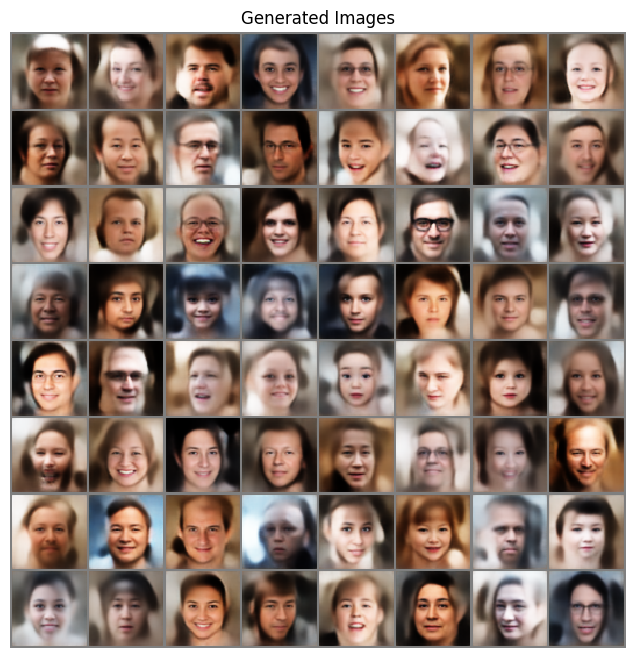

Epoch 50
[100/547]  loss: (l1=0.0827 ssim=0.3181 -> 1.0842) vae=0.1029 -> 1.1871
[200/547]  loss: (l1=0.0767 ssim=0.3049 -> 1.0370) vae=0.1047 -> 1.1417
[300/547]  loss: (l1=0.0809 ssim=0.3175 -> 1.0806) vae=0.1005 -> 1.1811
[400/547]  loss: (l1=0.0801 ssim=0.3223 -> 1.0954) vae=0.1146 -> 1.2100
[500/547]  loss: (l1=0.0812 ssim=0.3203 -> 1.0899) vae=0.1088 -> 1.1987
Epoch 51
[100/547]  loss: (l1=0.0811 ssim=0.3252 -> 1.1055) vae=0.1073 -> 1.2127
[200/547]  loss: (l1=0.0809 ssim=0.3183 -> 1.0832) vae=0.1025 -> 1.1858
[300/547]  loss: (l1=0.0786 ssim=0.3138 -> 1.0671) vae=0.1105 -> 1.1776
[400/547]  loss: (l1=0.0790 ssim=0.3077 -> 1.0478) vae=0.1033 -> 1.1511
[500/547]  loss: (l1=0.0792 ssim=0.3094 -> 1.0535) vae=0.1014 -> 1.1549
Epoch 52
[100/547]  loss: (l1=0.0789 ssim=0.3174 -> 1.0790) vae=0.1034 -> 1.1824
[200/547]  loss: (l1=0.0806 ssim=0.3170 -> 1.0790) vae=0.1061 -> 1.1852
[300/547]  loss: (l1=0.0801 ssim=0.3150 -> 1.0721) vae=0.1048 -> 1.1769
[400/547]  loss: (l1=0.0839 ssim=0.32

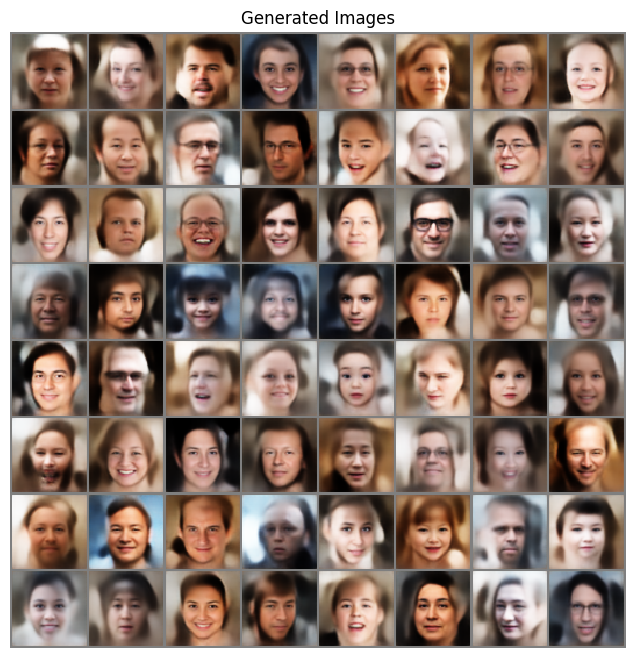

Epoch 65
[100/547]  loss: (l1=0.0789 ssim=0.3120 -> 1.0616) vae=0.1119 -> 1.1735
[200/547]  loss: (l1=0.0794 ssim=0.3151 -> 1.0718) vae=0.1026 -> 1.1744
[300/547]  loss: (l1=0.0818 ssim=0.3072 -> 1.0483) vae=0.1060 -> 1.1543
[400/547]  loss: (l1=0.0796 ssim=0.3115 -> 1.0604) vae=0.1029 -> 1.1633
[500/547]  loss: (l1=0.0781 ssim=0.3044 -> 1.0366) vae=0.0990 -> 1.1356
Epoch 66
[100/547]  loss: (l1=0.0815 ssim=0.3175 -> 1.0811) vae=0.1060 -> 1.1872
[200/547]  loss: (l1=0.0797 ssim=0.3164 -> 1.0763) vae=0.1119 -> 1.1883
[300/547]  loss: (l1=0.0791 ssim=0.3075 -> 1.0473) vae=0.1054 -> 1.1527
[400/547]  loss: (l1=0.0815 ssim=0.3124 -> 1.0650) vae=0.1067 -> 1.1717
[500/547]  loss: (l1=0.0803 ssim=0.3230 -> 1.0977) vae=0.1047 -> 1.2024
Epoch 67
[100/547]  loss: (l1=0.0797 ssim=0.3195 -> 1.0863) vae=0.1092 -> 1.1955
[200/547]  loss: (l1=0.0793 ssim=0.3101 -> 1.0557) vae=0.1109 -> 1.1666
[300/547]  loss: (l1=0.0767 ssim=0.2987 -> 1.0171) vae=0.1101 -> 1.1272
[400/547]  loss: (l1=0.0812 ssim=0.31

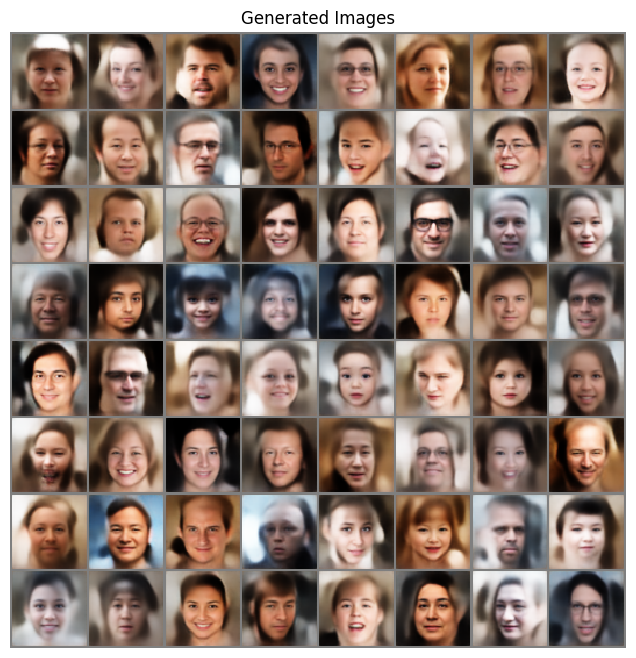

Epoch 82
[100/547]  loss: (l1=0.0788 ssim=0.3088 -> 1.0512) vae=0.1087 -> 1.1599
[200/547]  loss: (l1=0.0789 ssim=0.3024 -> 1.0308) vae=0.1117 -> 1.1425
[300/547]  loss: (l1=0.0797 ssim=0.3128 -> 1.0647) vae=0.1034 -> 1.1680
[400/547]  loss: (l1=0.0808 ssim=0.3091 -> 1.0538) vae=0.1054 -> 1.1592
[500/547]  loss: (l1=0.0794 ssim=0.3028 -> 1.0325) vae=0.1088 -> 1.1413
Epoch 83
[100/547]  loss: (l1=0.0806 ssim=0.3099 -> 1.0563) vae=0.1013 -> 1.1575
[200/547]  loss: (l1=0.0788 ssim=0.3088 -> 1.0513) vae=0.1072 -> 1.1585
[300/547]  loss: (l1=0.0794 ssim=0.3119 -> 1.0615) vae=0.1049 -> 1.1665
[400/547]  loss: (l1=0.0797 ssim=0.3099 -> 1.0553) vae=0.1040 -> 1.1594
[500/547]  loss: (l1=0.0800 ssim=0.3127 -> 1.0647) vae=0.1065 -> 1.1712
Epoch 84
[100/547]  loss: (l1=0.0794 ssim=0.3066 -> 1.0445) vae=0.1005 -> 1.1450
[200/547]  loss: (l1=0.0790 ssim=0.3088 -> 1.0515) vae=0.1101 -> 1.1616
[300/547]  loss: (l1=0.0837 ssim=0.3279 -> 1.1162) vae=0.1031 -> 1.2193
[400/547]  loss: (l1=0.0754 ssim=0.29

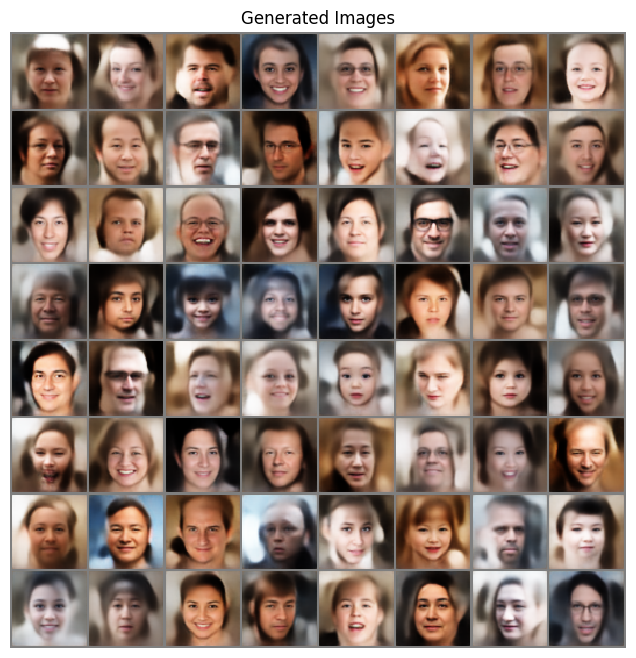

In [4]:
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM


def weights_init(m):
    classname = m.__class__.__name__
    if 'BatchNorm' in classname:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.normal_(m.bias.data, 0.0, 0.02)
    elif 'Linear' in classname:
        if 'weight' in m.__dict__ and m.weight is not None:
            nn.init.normal_(m.weight.data, 0.0, 0.1)
        if 'bias' in m.__dict__ and m.bias is not None:
            nn.init.normal_(m.bias.data, 0.0, 0.1)
    else:
        if 'weight' in m.__dict__ and m.weight is not None:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        if 'bias' in m.__dict__ and m.bias is not None:
            nn.init.normal_(m.bias.data, 0.0, 0.02)


def train_epoch(epoch, dataloader, net_e, net_g, loss_fn, optimizer_e, optimizer_g):

    net_e_params = torch.cat([x.view(-1) for x in net_e.parameters()])
    net_g_params = torch.cat([x.view(-1) for x in net_g.parameters()])

    for batch, x in enumerate(dataloader, 0):
        real = x.to(device)*2.0-1.0

        encoded = net_e(real)
        fake = net_g(encoded)

        # loss between real and fake
        loss_l1 = 0.5*torch.mean(torch.abs(fake-real))
        loss_ssim = 1 - ssim(0.5+0.5*real, 0.5+0.5*fake, data_range=1, size_average=True)
        ssim_t = 0.8 * np.clip((epoch-1)/(10-1), 0, 1)
        loss_diff = 4.0*((1-ssim_t)*loss_l1+ssim_t*loss_ssim)

        # KL divergence loss for VAE
        encoded_mean = torch.mean(encoded, axis=0)
        encoded_cov = torch.cov(encoded.T)
        p1 = torch.distributions.multivariate_normal.MultivariateNormal(
            encoded_mean, encoded_cov)
        p2 = torch.distributions.multivariate_normal.MultivariateNormal(
            torch.zeros_like(encoded_mean, device=device),
            torch.eye(LATENT, device=device))
        loss_vae = 0.01 * torch.distributions.kl_divergence(p1, p2)

        # train encoder/generator
        net_e.zero_grad()
        net_g.zero_grad()
        loss = loss_diff + loss_vae
        loss.backward()
        optimizer_e.step()
        optimizer_g.step()

        # output stats
        if (batch+1) % 100 == 0:
            print('[%d/%d]  loss: (l1=%.4f ssim=%.4f -> %.4f) vae=%.4f -> %.4f'
                  % (batch+1, len(dataloader),
                     loss_l1.item(),
                     loss_ssim.item(),
                     loss_diff.item(),
                     loss_vae.item(),
                     loss.item()))
            # break


def count_weights(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# load data
dataloader = load_data(FFHQDataset())

# creat models
net_e = Encoder().to(device)
print("Encoder", count_weights(net_e))
print(net_e)

net_g = Generator().to(device)
print("Decoder", count_weights(net_g))
print(net_g)

try:
    net_e.load_state_dict(torch.load(MODEL_E_PATH, map_location=device))
    net_g.load_state_dict(torch.load(MODEL_G_PATH, map_location=device))
    print("Model loaded from file.")
except BaseException as e:
    net_e.apply(weights_init)
    net_g.apply(weights_init)
    print("Model weights initialized.")

# loss function and optimizer
loss_fn = nn.BCELoss()
optimizer_e = torch.optim.Adam(net_e.parameters(),
                                lr=0.001, betas=(0.9, 0.999))
optimizer_g = torch.optim.Adam(net_g.parameters(),
                                lr=0.001, betas=(0.9, 0.999))

# train with progress
fixed_noise = torch.randn(64, LATENT, device=device)
for epoch in range(1, 100+1):
    # train
    print("Epoch", epoch)
    train_epoch(epoch, dataloader, net_e, net_g, loss_fn, optimizer_e, optimizer_g)
    # plot
    epoch_sqrt = int(epoch**0.5+1e-6)
    if epoch == epoch_sqrt**2:
        generated = net_g(fixed_noise)*0.5+0.5
        plt.figure(figsize=(8, 8))
        plt.axis("off")
        plt.title("Generated Images")
        plt.imshow(np.transpose(vutils.make_grid(
            generated,
            padding=2, pad_value=0.5, normalize=True).cpu(), (1, 2, 0)),
                    interpolation='nearest')
        plt.show() # on 

# export weights

torch.save(net_e.state_dict(), MODEL_E_PATH)
torch.save(net_g.state_dict(), MODEL_G_PATH)


Shape of x: torch.Size([128, 3, 64, 64])
Model loaded from file.


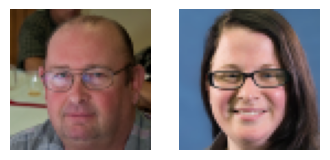

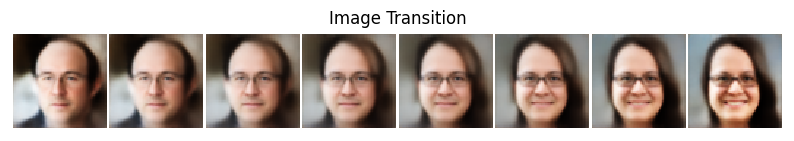

In [10]:
# load data
dataloader = load_data(FFHQDataset())

# creat models
net_e = Encoder().to(device)
net_g = Generator().to(device)

net_e.load_state_dict(torch.load(MODEL_E_PATH, map_location=device))
net_g.load_state_dict(torch.load(MODEL_G_PATH, map_location=device))
print("Model loaded from file.")

for batch in dataloader:
    img1 = batch[0:1]
    img2 = batch[1:2]
    # break

from PIL import Image
# img1 = torch.tensor([np.array(Image.open("/home/harry7557558/me.png").convert("RGB").resize((64,64)), dtype=np.float32)/255.0]).permute(0, 3, 1, 2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4, 10))
ax1.imshow(img1[0].permute(1, 2, 0))
ax2.imshow(img2[0].permute(1, 2, 0))
ax1.axis("off")
ax2.axis("off")
plt.show()

n = 8
enc1 = net_e(img1.to(device))
enc2 = net_e(img2.to(device))
t = torch.linspace(0, 1, n, device=device)
enc = enc1 + (enc2-enc1) * t[:, None]
img = net_g(enc)*0.5+0.5

plt.figure(figsize=(10, 30))
plt.axis("off")
plt.title("Image Transition")
plt.imshow(np.transpose(vutils.make_grid(
    img,
    padding=2, pad_value=1, normalize=True).cpu(), (1, 2, 0)),
            interpolation='nearest')
plt.show() # on ipynb


In [6]:
param_i = 0
layers = {}
prev_class = None
prev_path = None
for layer in net_g.main:
    if layer.__class__.__name__ == "Linear":
        param_i += 1
        data = list(layer.parameters())[0].data.cpu()
        shape = '_'.join(map(str, data.shape))
        path = EXPORT_PATH+"/w{:02d}_{}.bin".format(param_i, shape)
        layers[path] = data.numpy()
        prev_path = path
        if len(list(layer.parameters())) > 1:
            data = list(layer.parameters())[1].data.cpu()
            shape = '_'.join(map(str, data.shape))
            path = EXPORT_PATH+"/b{:02d}_{}.bin".format(param_i, shape)
            layers[path] = data.numpy()
            prev_path = (prev_path, path)
    elif layer.__class__.__name__ in ['Conv2d', "ConvTranspose2d"]:
        param_i += 1
        data = list(layer.parameters())[0].data.cpu()  # no bias
        shape = '_'.join(map(str, data.shape))
        path = EXPORT_PATH+"/w{:02d}_{}.bin".format(param_i, shape)
        layers[path] = data.numpy()
        prev_path = path
    elif layer.__class__.__name__ == "BatchNorm2d":
        assert len(layers[prev_path].shape) == 4
        mu = layer.running_mean.cpu()
        var = layer.running_var.cpu()
        invstdev = 1.0 / (var + 1e-5)**0.5
        data = list(layer.parameters())
        gamma, beta = data[0].data.cpu(), data[1].data.cpu()
        a = gamma * invstdev
        b = beta - mu * gamma * invstdev
        a, b = a.numpy(), b.numpy()
        # print(prev_class, layers[prev_path].shape, a.shape)
        if prev_class == 'ConvTranspose2d':
            layers[prev_path] = layers[prev_path] * a[:, np.newaxis, np.newaxis]
        elif prev_class == 'Conv2d':
            layers[prev_path] = layers[prev_path] * a[:, np.newaxis, np.newaxis, np.newaxis]
        # print(a.shape, b.shape, layers[prev_path].shape)
        shape = '_'.join(map(str, b.shape))
        path = EXPORT_PATH+"/b{:02d}_{}.bin".format(param_i, shape)
        layers[path] = b
    else:
        print(layer.__class__.__name__)
        prev_path = None
    prev_class = layer.__class__.__name__

for path, data in layers.items():
    data.astype(np.float32).tofile(path)

SiLU
Unflatten
SiLU
SiLU
SiLU
SiLU
Tanh
